In [3]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
#import sviewgui.sview as sv
import pandas as pd
import sys
import time
import numpy as np
import scipy as sp
#from scipy.optimize import root,fsolve
import pandas as pd
import sympy as sy
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
from sympy import lambdify,pprint,latex,sin,cos
from scipy import integrate,linalg 
from scipy.optimize import root, fsolve
from scipy.sparse import diags

定义函数

In [4]:

def 动力学扭矩计算(l1=0.1,l2=0.3,fi1=23.5/180*np.pi,initial_guess = [0.1, 0,0.25,0,3.14/2,0.3,0,0],
            m=10,j=10,g=9.8,f=1000000,
           dfi1=-55/60*2*np.pi,ddf1=0,位置=0.05):    
    # 初始猜测值
    # 初始猜测值
    #initial_guess = [0.1, 0,0.25,0,3.14/2,0.3,0,0]
    # 使用fsolve求解方程组  
    from sympy import lambdify,pprint,latex,sin,cos
    def equations(vars):
        x1,y1,x2,y2,fi2,x3,y3,fi3=vars
        eq1=[-0.5*l1*cos(fi1) + x1,
             -0.5*l1*sin(fi1) + y1, 
             -0.5*l1*cos(fi1) - 0.5*l2*sin(fi2) - x1 + x2, 
             -0.5*l1*sin(fi1) + 0.5*l2*cos(fi2) - y1 + y2,
             -0.5*l2*cos(fi2) + y2,
             -0.5*l1*cos(fi1) - l2*sin(fi2) - x1 + x3 + 位置,
             y3-y1,
             fi3-sy.pi/2]
        return eq1
    solution = fsolve(equations, initial_guess)  
    x1,y1,x2,y2,fi2,x3,y3,fi3=solution
    #print(solution)
    from numpy import sin,cos
    雅克比矩阵=np.array([[1, 0, 0.5*l1*sin(fi1), 0, 0, 0, 0, 0, 0], 
                     [0, 1, -0.5*l1*cos(fi1), 0, 0, 0, 0, 0, 0], 
                     [-1, 0, 0.5*l1*sin(fi1), 1, 0, -0.5*l2*cos(fi2), 0, 0, 0], 
                     [0, -1, -0.5*l1*cos(fi1), 0, 1, -0.5*l2*sin(fi2), 0, 0, 0], 
                     [0, 0, 0, 0, 1, 0.5*l2*sin(fi2), 0, 0, 0], 
                     [-1, 0, 0.5*l1*sin(fi1), 0, 0, -l2*cos(fi2), 1, 0, 0], 
                     [0, -1, 0, 0, 0, 0, 0, 1, 0], 
                     [0, 0, 0, 0, 0, 0, 0, 0, 1],
                    [0, 0, 1, 0, 0, 0, 0, 0, 0]])
    #print(雅克比矩阵)
    矩阵0=np.array([[0], [0], [0], [0], [0],[0],[0], [0],[dfi1]])
    xv = linalg.solve(雅克比矩阵, 矩阵0)
    #print(xv.T[0])
    dx1,dy1,dfi1,dx2,dy2,dfi2,dx3,dy3,dfi3=xv.T[0]
    
    #print(dx1)
    加速度右项=-np.array([[0.5*dfi1**2*l1*cos(fi1)], 
                     [0.5*dfi1**2*l1*sin(fi1)], 
                     [0.5*dfi1**2*l1*cos(fi1) + 0.5*dfi2**2*l2*sin(fi2)],
                     [0.5*dfi1**2*l1*sin(fi1) - 0.5*dfi2**2*l2*cos(fi2)],
                     [0.5*dfi2**2*l2*cos(fi2)], 
                     [0.5*dfi1**2*l1*cos(fi1) + dfi2**2*l2*sin(fi2)], 
                     [0], 
                     [0],
                    [ddf1]])
    xa = linalg.solve(雅克比矩阵,加速度右项)
    #print(xa.T[0])
    ddx1,ddy1,ddfi1,ddx2,ddy2,ddfi2,ddx3,ddy3,ddfi3=xa.T[0]
    加速度矩阵=np.array([[ddx1], [ddy1], [ddfi1], [ddx2], [ddy2],[ddfi2], [ddx3], [ddy3],[ddfi3]])
    #print(加速度矩阵)
    重力=-np.array([[0], [m*g], [0], [0], [m*g],[0],[0], [m*g],[0]])
    外力=np.array([[0], [0], [0], [0], [0],[0],[-f], [0],[0]])
    m11=diags(np.array([m,m,j]),0)
    m12=diags(np.array([m,m,j]),0)
    m13=diags(np.array([m,m,j]),0)
    #print(m13)
    质量阵=np.array([[m,0,0,0,0,0,0,0,0],
                    [0,m,0,0,0,0,0,0,0],
                    [0,0,j,0,0,0,0,0,0],
                    [0,0,0,m,0,0,0,0,0],
                    [0,0,0,0,m,0,0,0,0],
                    [0,0,0,0,0,j,0,0,0],
                    [0,0,0,0,0,0,m,0,0],
                    [0,0,0,0,0,0,0,m,0],
                    [0,0,0,0,0,0,0,0,j],]
                    )
    #print(质量阵)
    方程右项=-质量阵.dot(加速度矩阵)+外力+重力
    #pprint(方程右项)
    xf = linalg.solve(雅克比矩阵.T, 方程右项)
    #print(xf.T[0])
    #print('反推扭矩=',xf.T[0][8])#对比法
    return xf.T[0][8],solution,x3,
扭矩=动力学扭矩计算(l1=0.1,l2=0.3,fi1=23.5/180*np.pi,initial_guess = [0.1, 0,0.25,0,3.14/2,0.3,0,0],m=10,
    j=10,
    g=9.8,
    f=1000000,dfi1=-55/60*2*np.pi,ddf1=0)[0]
print("曲柄扭矩=",扭矩)

曲柄扭矩= 52169.22459091034


循环计算

In [5]:
spm=1#r/min
角速度=spm*2*np.pi/60#弧度/s
step=3600
#数据=pd.DataFrame()
角度=np.linspace(-np.pi,np.pi,step)
solution=[0.1, 0,0.25,0,3.14/2,0.3,0,0]
位移=np.linspace(0,2*np.pi,step)
扭矩=np.linspace(0,2*np.pi,step)
for i in range(len(角度)):
    结果=动力学扭矩计算(l1=0.1,l2=0.3,fi1=角度[i],initial_guess = solution,m=0.001,
        j=0.001,
        g=0,
        f=1000000,dfi1=角速度,ddf1=0)
    扭矩[i]=结果[0]
    位移[i]=结果[2]
    solution=结果[1]
print("计算完成")

计算完成


绘图

0.017546427746459814 -64562.6537896227


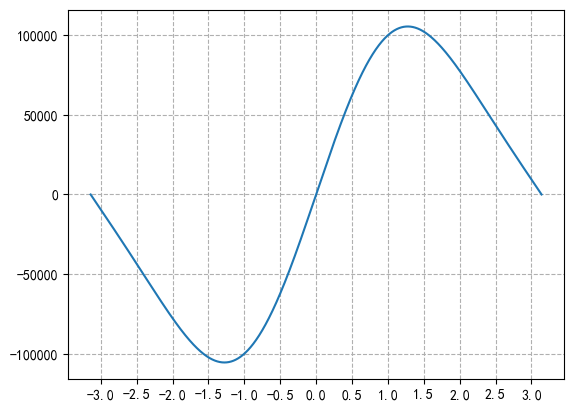

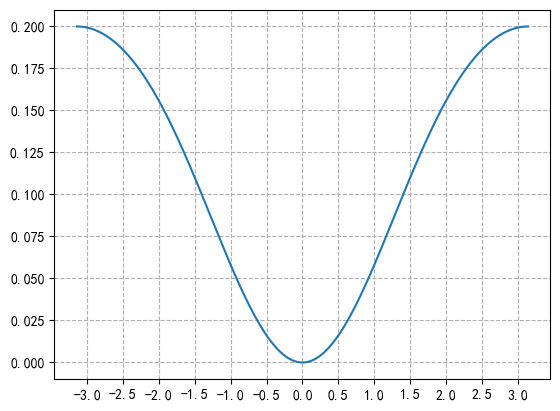

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from scipy.optimize import root,fsolve
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
x_major_locator = MultipleLocator(0.5)
y_major_locator = MultipleLocator(200)
y_major_locator1= MultipleLocator(0.5)
fig, ax = plt.subplots()
plt.plot(角度,扭矩)
ax.xaxis.set_major_locator(x_major_locator)
#ax.yaxis.set_major_locator(y_major_locator)
plt.grid(linestyle='--')
fig, ax1 = plt.subplots()
距离下死点位置=max(位移)-位移
ax1.plot(角度,距离下死点位置)
ax1.xaxis.set_major_locator(x_major_locator)
#ax1.yaxis.set_major_locator(y_major_locator1)
plt.grid(linestyle='--')
位置=1500
print(距离下死点位置[位置],扭矩[位置])